In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader,TensorDataset
import torch.optim as optim

In [26]:
import scipy.stats

In [37]:
input_size = 5

bn = nn.BatchNorm1d(input_size)

In [45]:
bn.eval()

BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [41]:
x = torch.FloatTensor(
    np.column_stack([
        scipy.stats.dweibull.rvs(c=2.07,size=10000)*np.random.randint(5000),
        scipy.stats.kappa4.rvs(0.1,0,size=10000)*np.random.randint(5000),
        scipy.stats.laplace.rvs(size=10000)*np.random.randint(5000),
        scipy.stats.maxwell.rvs(size=10000)*np.random.randint(5000),
        scipy.stats.halfnorm.rvs(size=10000)*np.random.randint(5000),        
    ])
    )

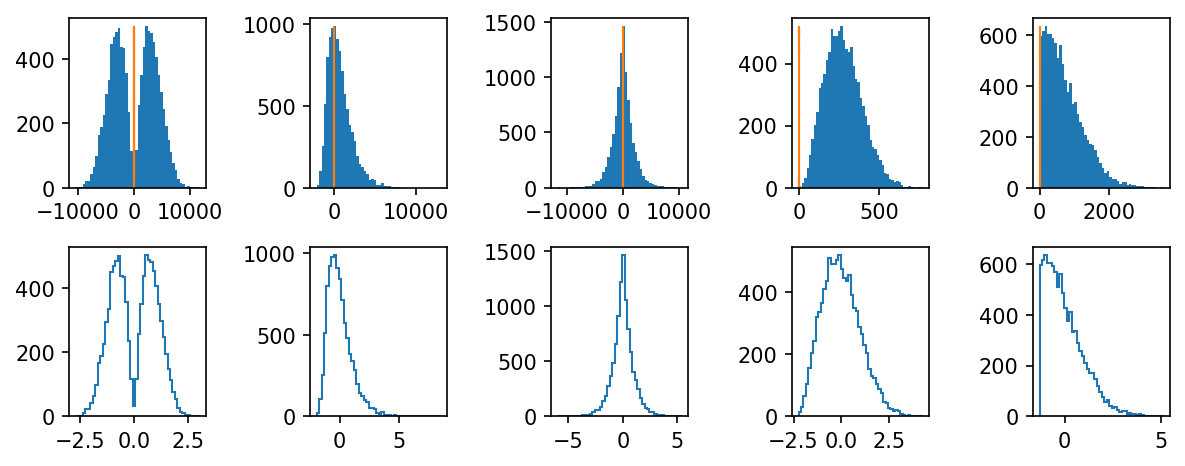

In [42]:
fig,ax = plt.subplots(2,input_size,figsize=(8,2*(8/input_size)),dpi=150)

for column_i in range(input_size):
    ax[0][column_i].hist(x[:,column_i],bins=50)
    
    
    bn_output = bn(x).data.numpy()
    ax[0][column_i].hist(bn_output[:,column_i],bins=50,histtype='step')
    ax[1][column_i].hist(bn_output[:,column_i],bins=50,histtype='step')
     
plt.tight_layout()
plt.show()

In [43]:
bn.running_mean

tensor([ 15.0516, 293.9998,  -1.3008, 113.1592, 297.5974])

In [44]:
bn.running_var

tensor([6.0442e+06, 8.6977e+05, 1.5579e+06, 5.4768e+03, 1.2532e+05])

In [46]:
for p in bn.parameters():
    print(p)

Parameter containing:
tensor([1., 1., 1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)


In [47]:
A_size = 10

In [48]:
A = np.random.normal(0,1,size=(A_size,A_size))

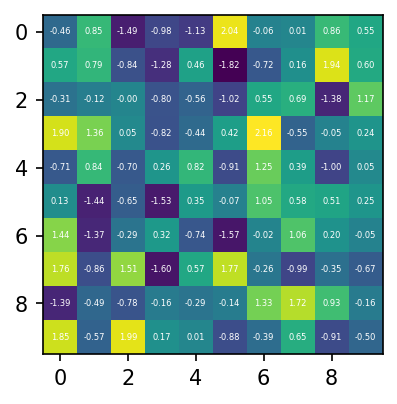

In [49]:
fig,ax =plt.subplots(figsize=(3,3),dpi=150)

ax.imshow(A)

for i in range(len(A)):
    for j in range(len(A[0])):
        text = ax.text(j, i, '{0:.2f}'.format(A[i, j]),fontsize=4,
                       ha="center", va="center", color="w")
        
plt.show()

In [50]:
N_points = 1000
batch_size = 1000
xs = np.random.normal(0,1,size=(N_points,A_size))

In [51]:
xs.shape

(1000, 10)

In [52]:
ys = np.array([ np.matmul(A,x) for x in xs])


In [15]:
ys.shape

(1000, 10)

In [53]:
X = torch.FloatTensor( xs )
Y = torch.FloatTensor( ys )

dataset = TensorDataset(X, Y)

In [54]:
dataloader = DataLoader(dataset,batch_size=batch_size)

In [55]:
class Net(nn.Module):
    def __init__(self,input_size,layer_sizes,use_bn=False):
        super(Net,self).__init__()
        
        self.use_batch_norm = use_bn
        
        self.layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        
        self.layer1 = nn.Linear(input_size,layer_sizes[0])
        for hidden_i in range(1,len(layer_sizes)):
            use_bias = True
            if use_bn:
                use_bias = False
                
            self.layers.append(nn.Linear(layer_sizes[hidden_i-1],layer_sizes[hidden_i],bias=use_bias))
        self.layer2 = nn.Linear(layer_sizes[-1],input_size)
        
        
        if use_bn:
            for hidden_i in range(1,len(layer_sizes)):
                self.bn_layers.append(nn.BatchNorm1d(layer_sizes[hidden_i]))
    
    def forward(self,x):
        
        out = self.layer1(x)
        
        
        for hidden_i, layer in enumerate( self.layers ):
            out = layer(out)
            if self.use_batch_norm:
                out = self.bn_layers[hidden_i](out)
            
        out =   self.layer2(out) 
        return out

In [56]:
net = Net(10,[10]*23)
net_with_bn = Net(10,[10]*23,True)

In [57]:
loss_func = nn.MSELoss()

In [58]:
optimizer = optim.Adam(net.parameters(), lr=1e-4) 

In [59]:
optimizer2 = optim.Adam(net_with_bn.parameters(), lr=1e-4) 

In [60]:
from tqdm.notebook import tqdm

def train_one_epoch(nn,optimizer):
    batch_losses = []
    nn.train()
    for x,y in dataloader:
        optimizer.zero_grad()
        
        output = nn(x)
        loss = loss_func(output,y)
        
        batch_losses.append(loss.item())
        
        loss.backward()  
        optimizer.step()
    return np.mean(batch_losses)

n_epochs = 1000

loss_vs_epoch = []

for epoch in tqdm( range(n_epochs) ):

    loss_vs_epoch.append([train_one_epoch(net,optimizer)
                         ,train_one_epoch(net_with_bn,optimizer2)] )

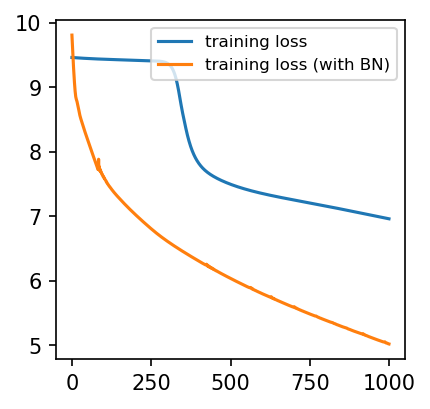

In [61]:
fig,ax = plt.subplots(figsize=(3,3),dpi=150)


loss_vs_epoch = np.array(loss_vs_epoch)

ax.plot(loss_vs_epoch[:,0],label='training loss')


ax.plot(loss_vs_epoch[:,1],label='training loss (with BN)')


ax.legend(fontsize=8)


plt.show()